## Imports

In [ ]:
import optuna.visualization as viz
from plotly.io import show
from utils.config import CFG
import joblib
from hyperopt import *

from models.ProtTransClassifier import ProtTransClassifier
from utils.cross_validation import kfoldCV
from utils.training_utils import init_trainer, init_loaders
from utils.dataset_utils import load_csv
from utils.plotting import plot_history
from ProteinDataset import ProtTransDataset
from Trainer import EarlyStopping
from torch.utils.data import DataLoader
import pandas as pd
import torch
from sklearn.metrics import balanced_accuracy_score

import plotly.io as pio
pio.renderers.default = "png"

# Model optimization for 100 classes

We perform both Neural Architecture Search and hyperparameter optimization using bayesian optimization.

In [2]:
model_config = CFG['ProtTransMLP']
model = ProtTransClassifier(model_config)

In [ ]:
study = optimize_hyperparameters(
    model, 
    model_config,
    obj_builder=objective_MLP,
    n_trials=CFG['hyperopt']['num_trials']
)

In [4]:
path = CFG.root_dir / CFG["paths"]["save_dir"] / "optuna"
study = joblib.load(path / 'ProtTransClassifier_100classes_study.pkl')
apply_best_config(study, model_config)

print("Best hyperparameters found: ")
for param in study.best_params:
    print(f"{param}: {study.best_params[param]}")

Best hyperparameters found: 
n_hidden: 1
hidden_dim_0: 2048
batch_norm: True
learning_rate: 1.6962423603621863e-05
weight_decay: 0.004802436224196309


## Perform cross-validation on optimized model

In [ ]:
df = load_csv(CFG.train_data)
dataset = ProtTransDataset(df, CFG.train_data)

model = ProtTransClassifier(CFG['ProtTransMLP'])
trainer = init_trainer(model, CFG['ProtTransMLP'])

ES = EarlyStopping(patience=12)

CV_loss = kfoldCV(trainer, dataset, 5, CFG['ProtTransMLP']['training']['epochs'])

In [6]:
print(f"k_fold CV loss: {CV_loss}")

k_fold CV loss: 0.08327397339083209


## Visualize hyperopt statistics

#### Hyperparameter importance

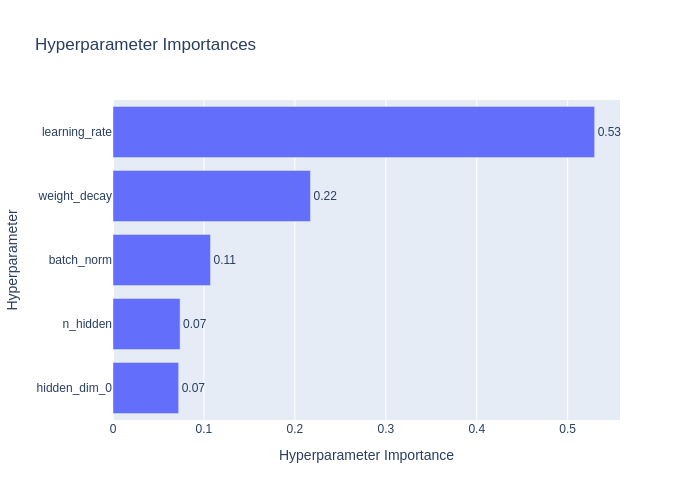

In [7]:
path = CFG.root_dir / CFG["paths"]["save_dir"] / "optuna"
study_name = "ProtTransClassifier_100classes_study.pkl"
study = joblib.load(path / study_name)
fig = viz.plot_param_importances(study)
show(fig)

#### 2D contour plot of hyperparameter correlation and influence on model loss

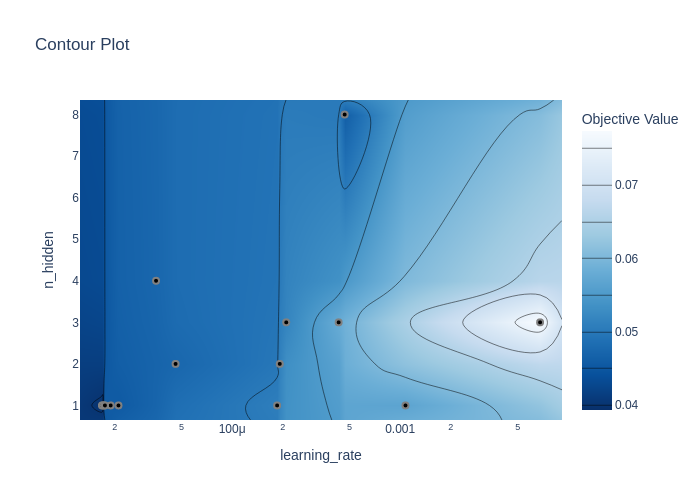

In [8]:
fig = viz.plot_contour(study, params=["n_hidden", "learning_rate"])
show(fig)

#### Optimization timeline

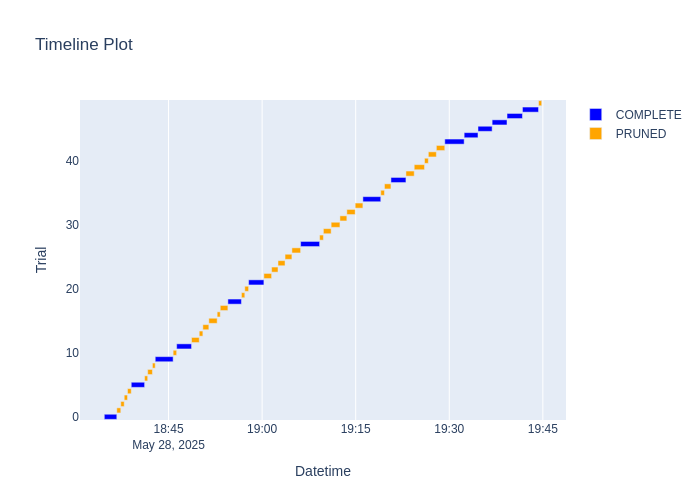

In [9]:
fig = viz.plot_timeline(study)
show(fig)

## Final Model Training

In [10]:
model_cfg = CFG["ProtTransMLP"]

train_loader, val_loader = init_loaders(model_cfg)
model = ProtTransClassifier(model_cfg)
trainer = init_trainer(model, model_cfg)
ES = EarlyStopping(patience=10)

trainer.train(train_loader, val_loader, epochs=30, early_stopping=ES)


Epoch 1/30:   0%|          | 0/668 [00:00<?, ?it/s]

[1/30] Train Loss: 0.7687


Evaluation:   0%|          | 0/118 [00:00<?, ?it/s]

	accuracy: 0.9894
	f1_score: 0.9890
[1/30] Val Loss: 0.1034 



Epoch 2/30:   0%|          | 0/668 [00:00<?, ?it/s]

[2/30] Train Loss: 0.0822


Evaluation:   0%|          | 0/118 [00:00<?, ?it/s]

	accuracy: 0.9916
	f1_score: 0.9915
[2/30] Val Loss: 0.0573 



Epoch 3/30:   0%|          | 0/668 [00:00<?, ?it/s]

[3/30] Train Loss: 0.0505


Evaluation:   0%|          | 0/118 [00:00<?, ?it/s]

	accuracy: 0.9921
	f1_score: 0.9921
[3/30] Val Loss: 0.0509 



Epoch 4/30:   0%|          | 0/668 [00:00<?, ?it/s]

[4/30] Train Loss: 0.0386


Evaluation:   0%|          | 0/118 [00:00<?, ?it/s]

	accuracy: 0.9932
	f1_score: 0.9932
[4/30] Val Loss: 0.0401 



Epoch 5/30:   0%|          | 0/668 [00:00<?, ?it/s]

[5/30] Train Loss: 0.0315


Evaluation:   0%|          | 0/118 [00:00<?, ?it/s]

	accuracy: 0.9936
	f1_score: 0.9935
[5/30] Val Loss: 0.0358 



Epoch 6/30:   0%|          | 0/668 [00:00<?, ?it/s]

[6/30] Train Loss: 0.0279


Evaluation:   0%|          | 0/118 [00:00<?, ?it/s]

	accuracy: 0.9927
	f1_score: 0.9927
[6/30] Val Loss: 0.0414 



Epoch 7/30:   0%|          | 0/668 [00:00<?, ?it/s]

[7/30] Train Loss: 0.0227


Evaluation:   0%|          | 0/118 [00:00<?, ?it/s]

	accuracy: 0.9927
	f1_score: 0.9927
[7/30] Val Loss: 0.0387 



Epoch 8/30:   0%|          | 0/668 [00:00<?, ?it/s]

[8/30] Train Loss: 0.0200


Evaluation:   0%|          | 0/118 [00:00<?, ?it/s]

	accuracy: 0.9925
	f1_score: 0.9925
[8/30] Val Loss: 0.0350 



Epoch 9/30:   0%|          | 0/668 [00:00<?, ?it/s]

[9/30] Train Loss: 0.0190


Evaluation:   0%|          | 0/118 [00:00<?, ?it/s]

	accuracy: 0.9925
	f1_score: 0.9925
[9/30] Val Loss: 0.0414 



Epoch 10/30:   0%|          | 0/668 [00:00<?, ?it/s]

[10/30] Train Loss: 0.0162


Evaluation:   0%|          | 0/118 [00:00<?, ?it/s]

	accuracy: 0.9928
	f1_score: 0.9929
[10/30] Val Loss: 0.0368 



Epoch 11/30:   0%|          | 0/668 [00:00<?, ?it/s]

[11/30] Train Loss: 0.0149


Evaluation:   0%|          | 0/118 [00:00<?, ?it/s]

	accuracy: 0.9943
	f1_score: 0.9943
[11/30] Val Loss: 0.0336 



Epoch 12/30:   0%|          | 0/668 [00:00<?, ?it/s]

[12/30] Train Loss: 0.0143


Evaluation:   0%|          | 0/118 [00:00<?, ?it/s]

	accuracy: 0.9926
	f1_score: 0.9926
[12/30] Val Loss: 0.0409 



Epoch 13/30:   0%|          | 0/668 [00:00<?, ?it/s]

[13/30] Train Loss: 0.0129


Evaluation:   0%|          | 0/118 [00:00<?, ?it/s]

	accuracy: 0.9929
	f1_score: 0.9930
[13/30] Val Loss: 0.0372 



Epoch 14/30:   0%|          | 0/668 [00:00<?, ?it/s]

[14/30] Train Loss: 0.0124


Evaluation:   0%|          | 0/118 [00:00<?, ?it/s]

	accuracy: 0.9935
	f1_score: 0.9936
[14/30] Val Loss: 0.0325 



Epoch 15/30:   0%|          | 0/668 [00:00<?, ?it/s]

[15/30] Train Loss: 0.0124


Evaluation:   0%|          | 0/118 [00:00<?, ?it/s]

	accuracy: 0.9941
	f1_score: 0.9941
[15/30] Val Loss: 0.0341 



Epoch 16/30:   0%|          | 0/668 [00:00<?, ?it/s]

[16/30] Train Loss: 0.0117


Evaluation:   0%|          | 0/118 [00:00<?, ?it/s]

	accuracy: 0.9931
	f1_score: 0.9930
[16/30] Val Loss: 0.0344 



Epoch 17/30:   0%|          | 0/668 [00:00<?, ?it/s]

[17/30] Train Loss: 0.0110


Evaluation:   0%|          | 0/118 [00:00<?, ?it/s]

	accuracy: 0.9935
	f1_score: 0.9934
[17/30] Val Loss: 0.0366 



Epoch 18/30:   0%|          | 0/668 [00:00<?, ?it/s]

[18/30] Train Loss: 0.0098


Evaluation:   0%|          | 0/118 [00:00<?, ?it/s]

	accuracy: 0.9929
	f1_score: 0.9929
[18/30] Val Loss: 0.0337 



Epoch 19/30:   0%|          | 0/668 [00:00<?, ?it/s]

[19/30] Train Loss: 0.0100


Evaluation:   0%|          | 0/118 [00:00<?, ?it/s]

	accuracy: 0.9930
	f1_score: 0.9930
[19/30] Val Loss: 0.0368 



Epoch 20/30:   0%|          | 0/668 [00:00<?, ?it/s]

[20/30] Train Loss: 0.0094


Evaluation:   0%|          | 0/118 [00:00<?, ?it/s]

	accuracy: 0.9927
	f1_score: 0.9927
[20/30] Val Loss: 0.0367 



Epoch 21/30:   0%|          | 0/668 [00:00<?, ?it/s]

[21/30] Train Loss: 0.0086


Evaluation:   0%|          | 0/118 [00:00<?, ?it/s]

	accuracy: 0.9934
	f1_score: 0.9935
[21/30] Val Loss: 0.0355 



Epoch 22/30:   0%|          | 0/668 [00:00<?, ?it/s]

[22/30] Train Loss: 0.0082


Evaluation:   0%|          | 0/118 [00:00<?, ?it/s]

	accuracy: 0.9924
	f1_score: 0.9924
[22/30] Val Loss: 0.0467 



Epoch 23/30:   0%|          | 0/668 [00:00<?, ?it/s]

[23/30] Train Loss: 0.0095


Evaluation:   0%|          | 0/118 [00:00<?, ?it/s]

	accuracy: 0.9923
	f1_score: 0.9924
[23/30] Val Loss: 0.0436 



Epoch 24/30:   0%|          | 0/668 [00:00<?, ?it/s]

[24/30] Train Loss: 0.0083


Evaluation:   0%|          | 0/118 [00:00<?, ?it/s]

	accuracy: 0.9927
	f1_score: 0.9928
[24/30] Val Loss: 0.0355 
Stopping training due to EarlyStopping


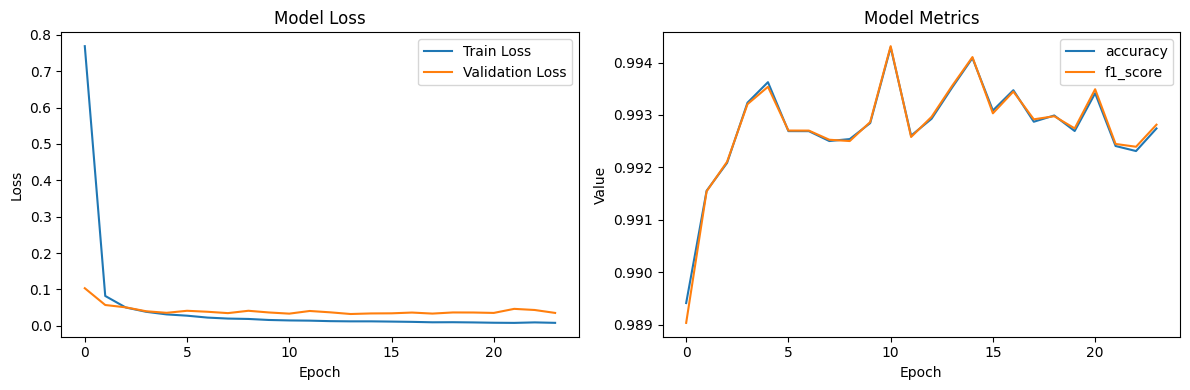

In [11]:
plot_history(trainer.history)

In [12]:
trainer.save_model(CFG.root_dir / 'outputs/trained_models')
trainer.save_history(CFG.root_dir / 'outputs/training_history')

Model ProtTransClassifier_100class.pt saved to /home/matteo/Desktop/DeepLife/protein-function-prediction/outputs/trained_models
History ProtTransClassifier_100class_history.pt saved to /home/matteo/Desktop/DeepLife/protein-function-prediction/outputs/training_history


## Save test predictions to csv

In [13]:
df_test = load_csv(CFG.test_data)
test_data = ProtTransDataset(df_test, CFG.test_data)
test_loader = DataLoader(test_data, batch_size=256, num_workers=8)

y_pred, y_true, _ = trainer.predict(test_loader) 
print(f"Test accuracy: {balanced_accuracy_score(y_pred, y_true, adjusted=True)}")

Evaluation:   0%|          | 0/139 [00:00<?, ?it/s]

Test accuracy: 0.924802514625443


Save predictions to csv

In [14]:
def int_to_onehot(y, num_classes=CFG.num_classes):
    mat = torch.zeros((len(y), num_classes+1))
    for i, idx in enumerate(y):
        mat[i, idx] = 1
    return mat

In [15]:
y_pred_onehot = int_to_onehot(y_pred, CFG.num_classes)

encoder = test_data.label_encoder
y_pred_names = encoder.inverse_transform(y_pred_onehot)

df_pred = pd.Series(y_pred_names, name='prediction')

df_pred = pd.concat([df_test['sequence'], df_pred], axis=1)
df_pred.to_csv(CFG.root_dir / 'outputs/predictions/ProtTransClassifier_100classes_predictions.csv', index=False)